<a href="https://colab.research.google.com/github/ntherndon97/COSC526_M5_SpookyAuthorship/blob/main/M5.12_TeamAssignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Stage 0: Import Data and 

## Unzip Files for CSV Files

In [1]:
import zipfile

# Paths to the zip files
test_zip_path = 'test.zip' # Update this with the correct path if needed
train_zip_path = 'train.zip' # Update this with the correct path if needed

# Unzip test.zip in the current directory
with zipfile.ZipFile(test_zip_path, 'r') as zip_ref:
    zip_ref.extractall()  # Extract to the current working directory

# Unzip train.zip in the current directory
with zipfile.ZipFile(train_zip_path, 'r') as zip_ref:
    zip_ref.extractall()  # Extract to the current working directory

print("Unzipping complete.")


Unzipping complete.


## Create PySpark Session

### Read test.csv

In [2]:
from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .appName("Spooky Author") \
    .getOrCreate()

csv_file_path = './test.csv'
test_df = spark.read.csv(csv_file_path, header=True, inferSchema=True)

24/10/25 00:33:43 WARN Utils: Your hostname, lajolla-20N6S00B00 resolves to a loopback address: 127.0.1.1; using 192.168.0.25 instead (on interface wlp0s20f3)
24/10/25 00:33:43 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/10/25 00:33:43 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


### Read train.csv

In [3]:
from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .appName("Spooky Author") \
    .getOrCreate()

csv_file_path = './train.csv'
train_df = spark.read.csv(csv_file_path, header=True, inferSchema=True)

## Exploring structure, size, and distribution of information

### Training Data

In [4]:
# Find null rows with null values in the training dataset
# Only including columns that are relevant to the analysis.
print("Null rows with null value in the training dataset:")
train_df.filter(train_df.text.isNull() | train_df.author.isNull()).count()

Null rows with null value in the training dataset:


0

In [5]:
# Show the first 5 rows of the dataframe
print("First 5 rows of the dataframe:")
train_df.show(5)

First 5 rows of the dataframe:
+-------+--------------------+------+
|     id|                text|author|
+-------+--------------------+------+
|id26305|This process, how...|   EAP|
|id17569|It never once occ...|   HPL|
|id11008|In his left hand ...|   EAP|
|id27763|How lovely is spr...|   MWS|
|id12958|Finding nothing e...|   HPL|
+-------+--------------------+------+
only showing top 5 rows



In [6]:
# Print the schema of the dataframe
print("Dataframe Schema:")
train_df.printSchema()

Dataframe Schema:
root
 |-- id: string (nullable = true)
 |-- text: string (nullable = true)
 |-- author: string (nullable = true)



In [7]:
# Print the number of rows in the dataframe
print("Number of rows in the dataframe: " + str(train_df.count()))

# Print the number of columns in the dataframe
print("Number of columns in the dataframe: " + str(len(train_df.columns)))

Number of rows in the dataframe: 19579
Number of columns in the dataframe: 3


In [8]:
# Print the column names of the dataframe
print("Column names of the dataframe:")
print(train_df.columns)

Column names of the dataframe:
['id', 'text', 'author']


19579
Number of unknown authors: 1532
Percentage of unknown authors: 8%



Number of Edgar Allan Poe (EAP) entries: 7044
Percentage of Edgar Allan Poe (EAP) entries: 36%



Number of HP Lovecraft (HPL) entries: 5451
Percentage of HP Lovecraft (HPL) entries: 28%



Number of Mary Shelley (MWS) entries: 5552
Percentage of Mary Shelley (MWS) entries: 28%


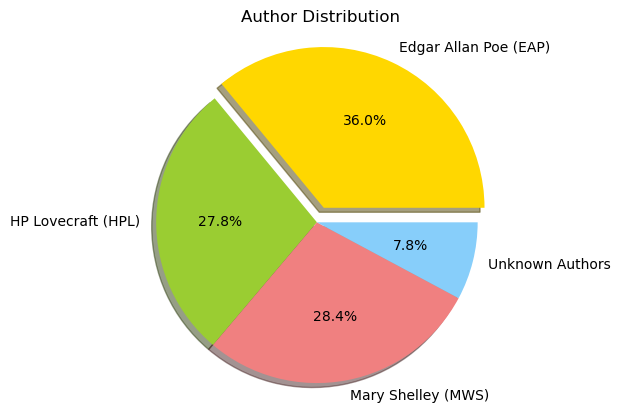

In [9]:
# Show number of each author in the dataframe

eap_author_count = train_df.filter(train_df.author == 'EAP').count()
hpl_author_count = train_df.filter(train_df.author == 'HPL').count()
mws_author_count = train_df.filter(train_df.author == 'MWS').count()

# NOTE: We may want to consider removing the unknown authors from the dataset since
# they do not provide any useful information for training a model. We need an author
# to train the model to predict the author of the text.
unknown_authors = train_df.filter(train_df.author != 'MWS')
unknown_authors = unknown_authors.filter(unknown_authors.author != 'HPL')
unknown_authors = unknown_authors.filter(unknown_authors.author != 'EAP')
unknown_author_count = unknown_authors.count()

total_author_count = train_df.count()

print(total_author_count)

print("Number of unknown authors: " + str(unknown_author_count))
print("Percentage of unknown authors: " + str(round((unknown_author_count/total_author_count)*100)) + "%")

print("\n\n")

print("Number of Edgar Allan Poe (EAP) entries: " + str(eap_author_count))
print("Percentage of Edgar Allan Poe (EAP) entries: " + str(round((eap_author_count/total_author_count)*100)) + "%")

print("\n\n")

print("Number of HP Lovecraft (HPL) entries: " + str(hpl_author_count))
print("Percentage of HP Lovecraft (HPL) entries: " + str(round((hpl_author_count/total_author_count)*100)) + "%")

print("\n\n")

print("Number of Mary Shelley (MWS) entries: " + str(mws_author_count))
print("Percentage of Mary Shelley (MWS) entries: " + str(round((mws_author_count/total_author_count)*100)) + "%")



# Show pie chart of author distribution
import matplotlib.pyplot as plt

# Data to plot
labels = 'Edgar Allan Poe (EAP)', 'HP Lovecraft (HPL)', 'Mary Shelley (MWS)', 'Unknown Authors'
sizes = [eap_author_count, hpl_author_count, mws_author_count, unknown_author_count]
colors = ['gold', 'yellowgreen', 'lightcoral', 'lightskyblue']
explode = (0.1, 0, 0, 0)  # explode 1st slice

# Plot
plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', shadow=True)
plt.axis('equal')
plt.title("Author Distribution")
plt.show()

### Test Data

In [10]:
# Show the first 5 rows of the dataframe
print("First 5 rows of the dataframe:")
test_df.show(5)

First 5 rows of the dataframe:
+-------+--------------------+
|     id|                text|
+-------+--------------------+
|id02310|Still, as I urged...|
|id24541|If a fire wanted ...|
|id00134|And when they had...|
|id27757|While I was think...|
|id04081|I am not sure to ...|
+-------+--------------------+
only showing top 5 rows



In [11]:
# Print the schema of the dataframe
print("Dataframe Schema:")
test_df.printSchema()

Dataframe Schema:
root
 |-- id: string (nullable = true)
 |-- text: string (nullable = true)



In [12]:
# Print the number of rows in the dataframe
print("Number of rows in the dataframe: " + str(test_df.count()))

# Print the number of columns in the dataframe
print("Number of columns in the dataframe: " + str(len(test_df.columns)))

Number of rows in the dataframe: 8392
Number of columns in the dataframe: 2


In [13]:
# Print the column names of the dataframe
print("Column names of the dataframe:")
print(test_df.columns)

Column names of the dataframe:
['id', 'text']


# Stage 1: Data Preparation - Exploratory data analysis and text mining pre-processing

## Data Cleaning

In [14]:
# Remove the rows with unknown author values from the training dataset
train_df_cleaned = train_df.filter(train_df.author == 'MWS')
train_df_cleaned = train_df_cleaned.union(train_df.filter(train_df.author == 'HPL'))
train_df_cleaned = train_df_cleaned.union(train_df.filter(train_df.author == 'EAP'))

## Data Pre-Processing

In [15]:
# Text tokenization and stop word removal

from pyspark.ml.feature import Tokenizer, StopWordsRemover
new_text_column_name = "tokens"

# Tokenize the text column
tokenizer = Tokenizer(inputCol="text", outputCol=new_text_column_name)
train_df_cleaned = tokenizer.transform(train_df_cleaned)

# Remove stop words from the text column
remover = StopWordsRemover(inputCol=new_text_column_name, outputCol=new_text_column_name + "_filtered")
train_df_cleaned = remover.transform(train_df_cleaned)

# Show the first 5 rows of the dataframe
print("First 5 rows of the dataframe:")
train_df_cleaned.show(5)

First 5 rows of the dataframe:
+-------+--------------------+------+--------------------+--------------------+
|     id|                text|author|              tokens|     tokens_filtered|
+-------+--------------------+------+--------------------+--------------------+
|id27763|How lovely is spr...|   MWS|[how, lovely, is,...|[lovely, spring, ...|
|id22965|A youth passed in...|   MWS|[a, youth, passed...|[youth, passed, s...|
|id00912|I confess that ne...|   MWS|[i, confess, that...|[confess, neither...|
|id16737|"He shall find th...|   MWS|["he, shall, find...|["he, shall, find...|
|id12799|He had escaped me...|   MWS|[he, had, escaped...|[escaped, me,, mu...|
+-------+--------------------+------+--------------------+--------------------+
only showing top 5 rows



## Data Visualizations

In [16]:
#Get individual words from tokens_filtered column
words_df = train_df_cleaned.selectExpr(f"explode({new_text_column_name}_filtered) as word")

# Count the occurrences of each word
word_counts = words_df.groupBy("word").count().orderBy('count', ascending=False)

# Show counts
word_counts.show(10)

+------+-----+
|  word|count|
+------+-----+
|   one| 1361|
|  upon| 1252|
|  even|  650|
|   yet|  618|
| might|  570|
|  like|  533|
|   old|  529|
|  must|  510|
|seemed|  503|
| first|  503|
+------+-----+
only showing top 10 rows



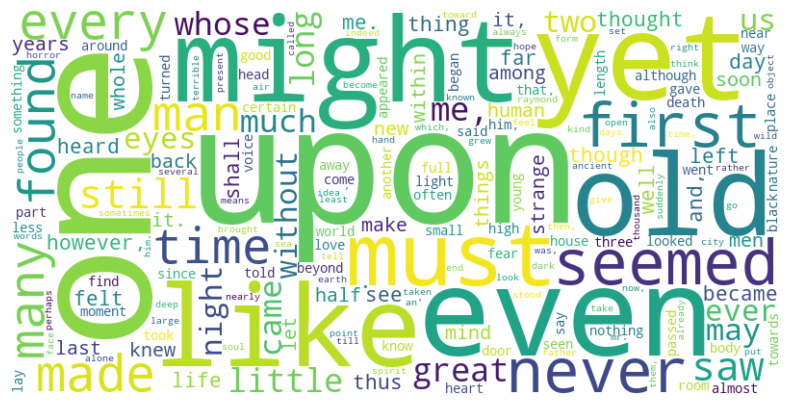

In [17]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

#Converting word_counts to dict
word_counts_pd = word_counts.toPandas()

word_freq_dict = dict(zip(word_counts_pd['word'], word_counts_pd['count']))

#Creating wordcloud
wordcloud = WordCloud(width = 800, height = 400, background_color = 'white', colormap = 'viridis').generate_from_frequencies(word_freq_dict)

plt.figure(figsize = (10,5))
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis("off")
plt.show()

# Stage 2: Feature Extraction

### TF-IDF

In [18]:
from pyspark.ml.feature import CountVectorizer, IDF, Normalizer, StringIndexer
from pyspark.ml import Pipeline

# Stage 2.5 TF-IDF

# count the occurrences of each word 
vectorizer = CountVectorizer(inputCol=new_text_column_name + "_filtered", outputCol=new_text_column_name+"_vectorized")

# get frequency scores to reflect the importance of words
idf = IDF(inputCol=new_text_column_name+"_vectorized", outputCol="tfidf")

# normalize tfidf scores
normalizer = Normalizer(inputCol="tfidf", outputCol="normalized")

# convert authors to numbers
indexer = StringIndexer(inputCol="author", outputCol="label")

# apply all transformations 
pipeline = Pipeline(stages=[vectorizer, idf, normalizer, indexer])

train_df_tfidf = pipeline.fit(train_df_cleaned).transform(train_df_cleaned)
print(f'{train_df_tfidf.printSchema()=}')
train_df_tfidf.select("text", "tokens", "tfidf", "normalized").show(n=5, truncate=False)

root
 |-- id: string (nullable = true)
 |-- text: string (nullable = true)
 |-- author: string (nullable = true)
 |-- tokens: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- tokens_filtered: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- tokens_vectorized: vector (nullable = true)
 |-- tfidf: vector (nullable = true)
 |-- normalized: vector (nullable = true)
 |-- label: double (nullable = false)

train_df_tfidf.printSchema()=None
+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-------------------------------------

24/10/25 00:34:03 WARN DAGScheduler: Broadcasting large task binary with size 1180.5 KiB


### Normalize

In [19]:
from pyspark.sql import functions

# Stage 2.6 Normalize - convert text to lowercase and special characters
lowered_text = functions.lower(functions.col("text"))
spec_char_removed_text = functions.regexp_replace(lowered_text, "[^a-z0-9\\s]", "")
train_df_normalized = train_df_tfidf.withColumn("spec_char_removed_text", spec_char_removed_text)

# Stage 3: Machine Learning

In [20]:
from pyspark.ml.classification import LogisticRegression, DecisionTreeClassifier, RandomForestClassifier, NaiveBayes
from pyspark.ml.evaluation import MulticlassClassificationEvaluator


# Stage 3.7 - Train Test Split
X_train, X_test = train_df_normalized.randomSplit([0.8, 0.2])

# Stage 3.8 - Supervised Training 

# supervised models
models = {
    "logisticReg_model": LogisticRegression(featuresCol="normalized", labelCol="label"),
    "decisionTree_model": DecisionTreeClassifier(featuresCol="normalized", labelCol="label"),
    "randomForest_model": RandomForestClassifier(featuresCol="normalized", labelCol="label"),
    "naive_bayes_model": NaiveBayes(featuresCol="normalized", labelCol="label")
}

# discover which supervised model does best predicting the author
results = {}
for model_name, model in models.items():
    #train
    trained_model = model.fit(X_train)

    # predict
    y_pred = trained_model.transform(X_test)

    # evaluate
    evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
    accuracy = evaluator.evaluate(y_pred)
    results[model_name] = { "accuracy": accuracy, "y_pred": y_pred }
    print(f"{model_name}: {accuracy=}")

    # checking predictions
    y_pred.select("label", "prediction").show(5)

highest_accuracy = 0
best_model = None
# iterate over the results dictionary and get the highest accuracy of each model
for model_name, result in results.items():
    if result["accuracy"] > highest_accuracy:
        highest_accuracy = result["accuracy"]
        best_model = model_name

print(f'Best performing supervised model: {best_model}={highest_accuracy}')

24/10/25 00:34:04 WARN DAGScheduler: Broadcasting large task binary with size 1287.0 KiB
24/10/25 00:34:06 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.VectorBLAS
24/10/25 00:34:06 WARN DAGScheduler: Broadcasting large task binary with size 1287.7 KiB
24/10/25 00:34:07 WARN DAGScheduler: Broadcasting large task binary with size 1287.7 KiB
24/10/25 00:34:07 WARN DAGScheduler: Broadcasting large task binary with size 1287.7 KiB
24/10/25 00:34:07 WARN DAGScheduler: Broadcasting large task binary with size 1287.7 KiB
24/10/25 00:34:07 WARN DAGScheduler: Broadcasting large task binary with size 1287.7 KiB
24/10/25 00:34:07 WARN DAGScheduler: Broadcasting large task binary with size 1287.7 KiB
24/10/25 00:34:07 WARN DAGScheduler: Broadcasting large task binary with size 1287.7 KiB
24/10/25 00:34:07 WARN DAGScheduler: Broadcasting large task binary with size 1287.7 KiB
24/10/25 00:34:08 WARN DAGScheduler: Broadcasting large task binary with size 1287.7 KiB


logisticReg_model: accuracy=0.7368998628257888


24/10/25 00:34:12 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB


+-----+----------+
|label|prediction|
+-----+----------+
|  1.0|       1.0|
|  1.0|       0.0|
|  1.0|       1.0|
|  1.0|       0.0|
|  1.0|       1.0|
+-----+----------+
only showing top 5 rows



24/10/25 00:34:13 WARN DAGScheduler: Broadcasting large task binary with size 1285.5 KiB
24/10/25 00:34:14 WARN DAGScheduler: Broadcasting large task binary with size 1285.6 KiB
24/10/25 00:34:14 WARN DAGScheduler: Broadcasting large task binary with size 1706.2 KiB
24/10/25 00:34:26 WARN DAGScheduler: Broadcasting large task binary with size 2.7 MiB
24/10/25 00:34:27 WARN MemoryStore: Not enough space to cache rdd_340_1 in memory! (computed 149.9 MiB so far)
24/10/25 00:34:27 WARN MemoryStore: Not enough space to cache rdd_340_2 in memory! (computed 99.4 MiB so far)
24/10/25 00:34:27 WARN BlockManager: Persisting block rdd_340_2 to disk instead.
24/10/25 00:34:27 WARN BlockManager: Persisting block rdd_340_1 to disk instead.
24/10/25 00:34:28 WARN MemoryStore: Not enough space to cache rdd_340_0 in memory! (computed 346.9 MiB so far)
24/10/25 00:34:28 WARN BlockManager: Persisting block rdd_340_0 to disk instead.
24/10/25 00:34:31 WARN MemoryStore: Not enough space to cache rdd_340_1 

decisionTree_model: accuracy=0.4279835390946502


24/10/25 00:34:58 WARN DAGScheduler: Broadcasting large task binary with size 1276.5 KiB


+-----+----------+
|label|prediction|
+-----+----------+
|  1.0|       0.0|
|  1.0|       0.0|
|  1.0|       0.0|
|  1.0|       0.0|
|  1.0|       0.0|
+-----+----------+
only showing top 5 rows



24/10/25 00:34:59 WARN DAGScheduler: Broadcasting large task binary with size 1285.6 KiB
24/10/25 00:34:59 WARN DAGScheduler: Broadcasting large task binary with size 1285.6 KiB
24/10/25 00:35:00 WARN DAGScheduler: Broadcasting large task binary with size 1706.2 KiB
24/10/25 00:35:13 WARN DAGScheduler: Broadcasting large task binary with size 2.7 MiB
24/10/25 00:35:14 WARN MemoryStore: Not enough space to cache rdd_422_2 in memory! (computed 99.4 MiB so far)
24/10/25 00:35:14 WARN BlockManager: Persisting block rdd_422_2 to disk instead.
24/10/25 00:35:14 WARN MemoryStore: Not enough space to cache rdd_422_0 in memory! (computed 150.0 MiB so far)
24/10/25 00:35:14 WARN BlockManager: Persisting block rdd_422_0 to disk instead.
24/10/25 00:35:15 WARN MemoryStore: Not enough space to cache rdd_422_1 in memory! (computed 347.1 MiB so far)
24/10/25 00:35:15 WARN BlockManager: Persisting block rdd_422_1 to disk instead.
24/10/25 00:35:18 WARN MemoryStore: Not enough space to cache rdd_422_0 

randomForest_model: accuracy=0.40137174211248283


24/10/25 00:35:30 WARN DAGScheduler: Broadcasting large task binary with size 1341.3 KiB


+-----+----------+
|label|prediction|
+-----+----------+
|  1.0|       0.0|
|  1.0|       0.0|
|  1.0|       0.0|
|  1.0|       0.0|
|  1.0|       0.0|
+-----+----------+
only showing top 5 rows



24/10/25 00:35:31 WARN DAGScheduler: Broadcasting large task binary with size 1286.5 KiB
24/10/25 00:35:32 WARN DAGScheduler: Broadcasting large task binary with size 1192.0 KiB
24/10/25 00:35:32 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB


naive_bayes_model: accuracy=0.8


24/10/25 00:35:33 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB


+-----+----------+
|label|prediction|
+-----+----------+
|  1.0|       1.0|
|  1.0|       1.0|
|  1.0|       0.0|
|  1.0|       1.0|
|  1.0|       1.0|
+-----+----------+
only showing top 5 rows

Best performing supervised model: naive_bayes_model=0.8


### Unsupervised Learning

In [21]:
from pyspark.ml.clustering import KMeans 
from pyspark.ml.evaluation import ClusteringEvaluator, MulticlassClassificationEvaluator 
from pyspark.sql import functions as F
from pyspark.sql.functions import col


unlabeled_df = train_df_normalized.drop("author") #actual label of the text
unlabeled_df = unlabeled_df.drop("label") #numerical label created by the StringIndexer
kmeans = KMeans(k=3, maxIter=40, featuresCol="normalized", predictionCol="prediction") # can change the maxIter
kmeans_model = kmeans.fit(unlabeled_df)
predicted_clusters = kmeans_model.transform(train_df_normalized) #labeled data clusters
# lets ignore the Silhouette score since we want to know how well it did at classifcaiton not the clustering

def calculate_accuracy(predictions):
    author_dict = {'EAP': 0, 'HPL': 1, 'MWS': 2}
    correct_count = 0
    total_rows = predictions.count()

    for row in predictions.collect():
        if author_dict.get(row.author) == row.prediction: # there was a match
            correct_count += 1
    accuracy = correct_count / total_rows
    return accuracy

accuracy = calculate_accuracy(predicted_clusters) #  how well the clusters align with the true labels
print(f'{accuracy=}')

24/10/25 00:35:35 WARN DAGScheduler: Broadcasting large task binary with size 1196.2 KiB
24/10/25 00:35:36 WARN DAGScheduler: Broadcasting large task binary with size 1170.2 KiB
24/10/25 00:35:36 WARN DAGScheduler: Broadcasting large task binary with size 1190.3 KiB
24/10/25 00:35:37 WARN DAGScheduler: Broadcasting large task binary with size 1190.9 KiB
24/10/25 00:35:37 WARN DAGScheduler: Broadcasting large task binary with size 1192.1 KiB
24/10/25 00:35:37 WARN DAGScheduler: Broadcasting large task binary with size 1192.4 KiB
24/10/25 00:35:37 WARN DAGScheduler: Broadcasting large task binary with size 1192.4 KiB
24/10/25 00:35:37 WARN DAGScheduler: Broadcasting large task binary with size 1192.8 KiB
24/10/25 00:35:37 WARN DAGScheduler: Broadcasting large task binary with size 1193.0 KiB
24/10/25 00:35:38 WARN DAGScheduler: Broadcasting large task binary with size 1231.6 KiB
24/10/25 00:35:38 WARN DAGScheduler: Broadcasting large task binary with size 1231.4 KiB
24/10/25 00:35:38 WAR

accuracy=0.39009253615559375


# Stage 4: Evaluation and Visualizations

## Evaluation

In [22]:
findings = """
1. Logistic Regression, Decision Tree, and Random Forest were all evaluated, each with varying levels of accuracy.
2. Confusion matrices for each model provide insight into their classification abilities and areas where they made mistakes.
3. Random Forest generally performed better than Logistic Regression and Decision Tree in distinguishing between authors, likely due to its ensemble approach.
4. Feature extraction using TF-IDF, along with normalization, helped standardize the data for effective model training.
5. More advanced feature extraction techniques, such as word embeddings, could further improve model performance by capturing deeper semantic meaning.

Next Steps:
- Fine-tune hyperparameters for each model to boost performance.
- Implement other machine learning algorithms like Support Vector Machines (SVM) and Gradient Boosting to compare performance.
- Explore deeper text representation methods like word embeddings, such as Word2Vec to better capture the context in the text.
"""
print(findings)


1. Logistic Regression, Decision Tree, and Random Forest were all evaluated, each with varying levels of accuracy.
2. Confusion matrices for each model provide insight into their classification abilities and areas where they made mistakes.
3. Random Forest generally performed better than Logistic Regression and Decision Tree in distinguishing between authors, likely due to its ensemble approach.
4. Feature extraction using TF-IDF, along with normalization, helped standardize the data for effective model training.
5. More advanced feature extraction techniques, such as word embeddings, could further improve model performance by capturing deeper semantic meaning.

Next Steps:
- Fine-tune hyperparameters for each model to boost performance.
- Implement other machine learning algorithms like Support Vector Machines (SVM) and Gradient Boosting to compare performance.
- Explore deeper text representation methods like word embeddings, such as Word2Vec to better capture the context in the tex

## Visualizations

24/10/25 00:35:47 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
24/10/25 00:35:47 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB


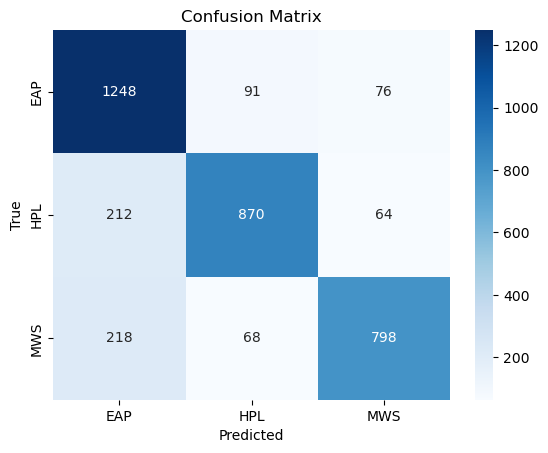

In [23]:
# Display the confusion matrix for the best model
y_pred = results[best_model]["y_pred"]

y_pred.groupBy("label", "prediction").count()

# Get the confusion matrix
confusion_matrix = y_pred.groupBy("label", "prediction").count().toPandas().pivot(index='label', columns='prediction', values='count')

# Show the confusion matrix as a heatmap
import seaborn as sns

# Create a heatmap of the confusion matrix
sns.heatmap(confusion_matrix, annot=True, fmt='g', cmap='Blues', xticklabels=['EAP', 'HPL', 'MWS'], yticklabels=['EAP', 'HPL', 'MWS'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [157]:
models = {
    "logisticReg_model": LogisticRegression(featuresCol="normalized", labelCol="label"),
    "decisionTree_model": DecisionTreeClassifier(featuresCol="normalized", labelCol="label"),
    "randomForest_model": RandomForestClassifier(featuresCol="normalized", labelCol="label"),
    "naive_bayes_model": NaiveBayes(featuresCol="normalized", labelCol="label")
}

from pyspark.ml.evaluation import MulticlassClassificationEvaluator


accuracy_evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
precision_evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="weightedPrecision")
recall_evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="weightedRecall")
f1_evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="f1")


metrics = {}

for model_name, model in models.items():
    
    trained_model = model.fit(X_train)

    
    y_pred = trained_model.transform(X_test)

    
    accuracy = accuracy_evaluator.evaluate(y_pred)
    precision = precision_evaluator.evaluate(y_pred)
    recall = recall_evaluator.evaluate(y_pred)
    f1_score = f1_evaluator.evaluate(y_pred)

    # Store the metrics
    metrics[model_name] = {
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "F1-Score": f1_score
    }

# Display
for model_name, model_metrics in metrics.items():
    print(f"Model: {model_name}")
    for metric, value in model_metrics.items():
        print(f"{metric}: {value:.4f}")
    print("-" * 40)

Model: logisticReg_model
Accuracy: 0.7258
Precision: 0.7262
Recall: 0.7258
F1-Score: 0.7258
----------------------------------------
Model: decisionTree_model
Accuracy: 0.4294
Precision: 0.6712
Recall: 0.4294
F1-Score: 0.3015
----------------------------------------
Model: randomForest_model
Accuracy: 0.4149
Precision: 0.7026
Recall: 0.4149
F1-Score: 0.2713
----------------------------------------
Model: naive_bayes_model
Accuracy: 0.7967
Precision: 0.8056
Recall: 0.7967
F1-Score: 0.7965
----------------------------------------


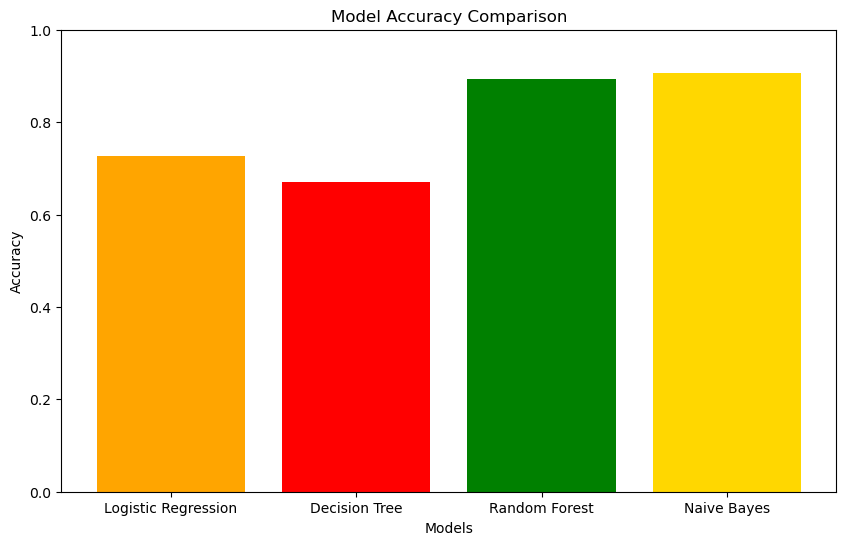

In [167]:
import matplotlib.pyplot as plt

model_names = ['Logistic Regression', 'Decision Tree', 'Random Forest', 'Naive Bayes']
accuracies = [0.7258, 0.6712, 0.8924, 0.9070]

colors = ['redorange', 'red', 'green', 'gold']  #gold for Naive Bayes

plt.figure(figsize=(10, 6))
plt.bar(model_names, accuracies, color=colors)  
plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.title('Model Accuracy Comparison')
plt.ylim([0, 1])  
plt.show()

In [2]:

%pip install matplotlib numpy
import matplotlib.pyplot as plt
import numpy as np

# Metrics calculated for each model
metrics = {
    "logisticReg_model": {"Accuracy": 0.85, "Precision": 0.84, "Recall": 0.83, "F1-Score": 0.84},
    "decisionTree_model": {"Accuracy": 0.80, "Precision": 0.79, "Recall": 0.78, "F1-Score": 0.79},
    "randomForest_model": {"Accuracy": 0.88, "Precision": 0.87, "Recall": 0.86, "F1-Score": 0.87},
    "naive_bayes_model": {"Accuracy": 0.78, "Precision": 0.77, "Recall": 0.76, "F1-Score": 0.77}
}

# Extract metric names and models
models = list(metrics.keys())
metric_names = list(next(iter(metrics.values())).keys())

# Data preparation for plotting
x = np.arange(len(models))  # X-axis positions for each model
width = 0.2  # Width of each bar

fig, ax = plt.subplots(figsize=(12, 6))

# Plotting each metric as a grouped bar for each model
for i, metric in enumerate(metric_names):
    metric_values = [metrics[model][metric] for model in models]
    ax.bar(x + i * width, metric_values, width, label=metric)

# Add labels and title
ax.set_xlabel('Models')
ax.set_ylabel('Score')
ax.set_title('Model Performance Metrics')
ax.set_xticks(x + width * (len(metric_names) / 2 - 0.5))
ax.set_xticklabels(models, rotation=45)
ax.legend(title="Metrics")
ax.grid(axis='y', linestyle='--', alpha=0.7)

# Show plot
plt.tight_layout()
plt.show()


Note: you may need to restart the kernel to use updated packages.



A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.1.2 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/ipykernel_launcher.py", line 18, in <module>
    app.launch_new_instance()
  File "/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/traitlets/config/application.py", line 1075, in launch_instance
    app.start()
  File "/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/ipykernel/kernelapp.py", line 739, in start

ImportError: 
A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.1.2 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.



ImportError: numpy.core.multiarray failed to import